In [0]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import imgaug

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
!pip install q keras==2.2.3

     |████████████████████████████████| 317kB 9.2MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

1.15.2


True

In [0]:
DATA_DIR = '/content/drive/My Drive/'

# Directory to save logs and trained model
ROOT_DIR = '/content/drive/My Drive/'

In [0]:
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 31.32 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [0]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
logs = DEFAULT_LOGS_DIR

Using TensorFlow backend.


In [0]:
dataset = "/content/drive/My Drive/Dataset/"
training_data_dir = "/content/drive/My Drive/Dataset/TrainingData/"
validation_data_dir = "/content/drive/My Drive/Dataset/ValidationData/"

In [0]:
class FaceConfig(Config):
    """Configuration for training Face detection on the dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = "Face"
    
    # Train on 1 GPU and 1 image per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 1 + 1  # background + 1 Face classes
    
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 0.33,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 0.33
    }

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.9
    STEPS_PER_EPOCH = 100

In [0]:
class FaceDataset(utils.Dataset):
    def load_face(self, dataset_dir, subset):
        self.add_class("Face", 1, "Face")
        
        assert subset in ["TrainingData", "ValidationData"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        annotations = json.load(open(os.path.join(dataset_dir, "Info.json")))
        
        for a in annotations:
            polygons = []
            objects = []
            for r in a['regions']:
                polygons.append(r['shape_attributes'])
            class_ids = [1 for n in polygons]
            
            if(a['filename']!="F089.jpg" and a['filename']!="F070.jpg"):
                # Removing a faulty file
                image_path = os.path.join(dataset_dir, a['filename'])
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]

                self.add_image(
                    "Face",
                    image_id=a['filename'],  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons,
                    class_ids=class_ids)
            
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        return info["path"]

In [0]:
class InferenceConfig(FaceConfig):
# Set batch size to 1 since we'll be running inference on
# one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.9

In [0]:
print('Preparing Train Dataset')
dataset_train = FaceDataset()
dataset_train.load_face(dataset, "TrainingData")
dataset_train.prepare()

print('Preparing Validation Dataset')
dataset_val = FaceDataset()
dataset_val.load_face(dataset, "ValidationData")
dataset_val.prepare()

print('Preparing Configs')
config = FaceConfig()
inf_config = InferenceConfig()

Preparing Train Dataset
Preparing Validation Dataset
Preparing Configs


In [0]:
print('Declaring Models')
# DEVICE = "/gpu:0"
# with tf.device(DEVICE):
model = modellib.MaskRCNN(mode="training", config=config,model_dir=logs)
model_inference = modellib.MaskRCNN(mode="inference", config=inf_config,model_dir=logs)

Declaring Models






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [0]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [0]:
model.load_weights("/content/Mask_RCNN/mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [0]:
mean_average_precision_callback = modellib.MeanAveragePrecisionCallback(model,model_inference, dataset_val, calculate_map_at_every_X_epoch=1, verbose=1)

In [0]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads'
            )


Starting at epoch 0. LR=0.001

Checkpoint Path: /contents/drive/My Drive/logs/face20200606T2150/mask_rcnn_face_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
100/100 [==============================] - 54s 540ms/step - loss: 0.9816 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.3116 - mrcnn_class_loss: 0.1731 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 0.9045 - val_rpn_class_loss: 0.0161 - val_rpn_bbox_loss: 0.4399 - val_mrcnn_class_loss: 0.0694 - val_mrcnn_bbox_loss: 0.3791 - val_mrcnn_mask_loss: 0.0000e+00

Epoch 2/10
100/100 [==============================] - 22s 216ms/step - loss: 0.6783 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 0.6820 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 0.2415 - val_mrcnn_class_loss: 0.1075 - val_mrcnn_bbox_loss: 0.3197 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 22s 218ms/step - loss: 0.5857 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.2471 - mrcnn_mask_loss: 0.0000e+00 - val_l

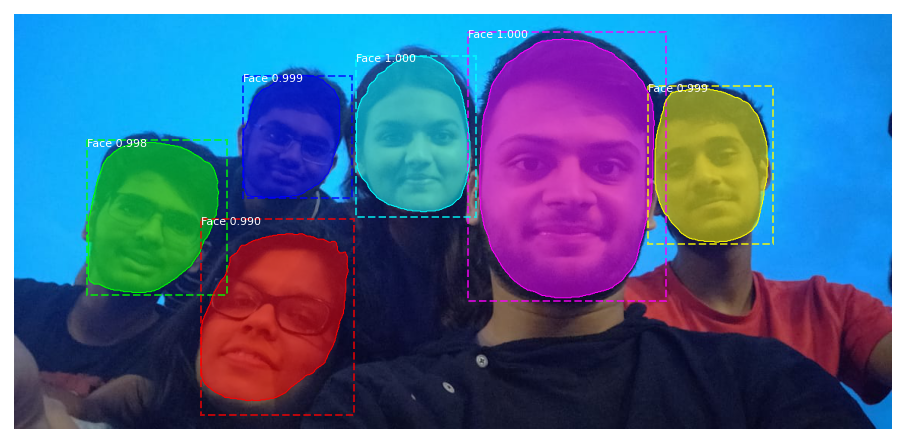

In [0]:
import random
import matplotlib.pyplot as plt
from PIL import Image

weights_path = "/content/drive/My Drive/EE769_APP/mask_rcnn_face_0010.h5"
MODEL_DIR = ""
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inf_config)
model.load_weights(weights_path, by_name=True)

image = Image.open("/content/drive/My Drive/Dataset/TrainingData/F067.jpg")
image = np.array(image)

res = model.detect([image], verbose=0)
r = res[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ["BG", "Face"], r['scores'],
                            title="")

In [0]:
!cd ../../; ls

bin					   lib	  srv
boot					   lib32  swift
content					   lib64  sys
contents				   media  tensorflow-1.15.2
datalab					   mnt	  tmp
dev					   opt	  tools
dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl  proc   usr
dlib-19.18.0-cp36-cp36m-linux_x86_64.whl   root   var
etc					   run
home					   sbin


['/content/drive/My Drive/EE769_APP/img1.png', '/content/drive/My Drive/EE769_APP/img2.png', '/content/drive/My Drive/EE769_APP/img3.png', '/content/drive/My Drive/EE769_APP/img4.png']


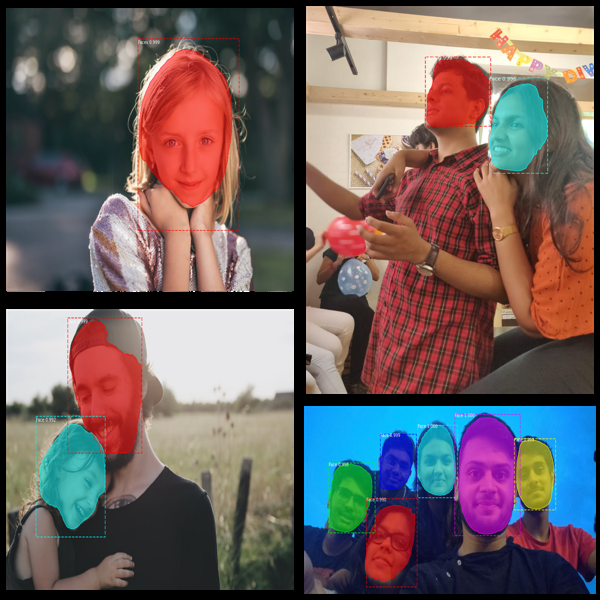

In [0]:
files = []
for i in range(4):
    files.append("/content/drive/My Drive/EE769_APP/img"+str(i+1)+".png")
print(files)

new_im = Image.new('RGB', (600,600))

im = Image.open(files[0])
im = im.resize((300,300))
new_im.paste(im,(0,0))

im = Image.open(files[1])
im = im.resize((300,300))
new_im.paste(im,(0,300))

im = Image.open(files[2])
im = im.resize((300,400))
new_im.paste(im,(300,0))

im = Image.open(files[3])
im = im.resize((300,200))
new_im.paste(im,(300,400))

new_im